# Microorganism Classification Project
**Author:** Kai Uechi

## Overview
temp

## Business Problem
A hospital needs to identify different types of microorganisms for a variety of reasons, like diagnosing infections and determining antibiotic resistance. Although modern DNA sequencing techniques have improved speed, it still takes several hours to receive results. Utilizing machine learning classification, it is possible to identify types of microorganisms faster and more economically than can be achieved with sequencing.


## Data Understanding
The dataset used in this project consists of information extracted from microscopic images. The dataset includes information regarding various genera and classes of fungi and algae, as well as protozoa. There are 10 categories in total.

Some of these microorganisms display antibiotic properties, such as penicillium and spirogyra.
Others, such as protozoa and yeast, are responsible for harmful infections.

The features included in this dataset are as follows:

* `Solidity` - Ratio of an object's area to the area of its convex hull
* `Eccentricity` - Ratio of the length of an object's major axis to the length of its minor axis
* `EquivDiameter` - The diameter of a circle with area equivalent to the region
* `Extrema` - Extrema points within the region
* `FilledArea` - Number of pixels, returned as a scalar
* `Extent` - Ratio of the area of a region in pixels to the area of the bounding box
* `Orientation` - Direction of the shape. (Values range from -90 to 90 degrees)
* `EulerNumber` - Number of objects in the region minus the number of holes in those objects
* `BoundingBox` - Size and position of the smallest rectangle that contains the object
* `ConvexHull` - Smallest convex polygon that contains the object
* `MajorAxisLength` - Length in pixels of the major axis of the object
* `MinorAxisLength` - Length in pixels of the minor axis of the object
* `Perimeter` - Total number of pixels around the border of the region
* `Centroid` - Object's location within the image
* `Area` - Total number of pixels in the region

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipe
from os.path import exists
import pickle
import joblib
import shap 

shap.initjs()
pd.set_option('display.max_columns', None)

np.random.seed(8492)

#import data
df = pd.read_csv('data/microbes.csv')
df.head()

,Unnamed: 0,Solidity,Eccentricity,EquivDiameter,Extrema,FilledArea,Extent,Orientation,EulerNumber,BoundingBox1,BoundingBox2,BoundingBox3,BoundingBox4,ConvexHull1,ConvexHull2,ConvexHull3,ConvexHull4,MajorAxisLength,MinorAxisLength,Perimeter,ConvexArea,Centroid1,Centroid2,Area,raddi,microorganisms
0,0,10.70,15.8,5.43,3.75,0.785,8.14,2.15,22.3,2.97,10.90,1.75,2.97,3.12,3.12,2.97,2.97,1.34,1.61,0.683,0.195,3.63,12.10,1.310,7.99,Spirogyra
1,1,5.60,18.3,4.14,6.16,0.364,3.51,18.60,22.5,5.41,19.20,1.77,3.95,6.08,6.08,5.49,5.47,1.52,1.52,1.010,0.215,6.01,20.60,0.765,7.99,Spirogyra
2,2,8.32,19.8,4.63,6.66,0.415,5.85,21.00,22.4,5.96,10.20,1.51,3.49,5.95,5.95,5.99,5.96,1.63,1.38,1.110,0.182,6.55,11.50,0.953,7.99,Spirogyra
3,3,10.10,17.9,7.29,11.10,1.470,6.30,9.94,21.9,8.81,10.70,3.34,3.63,8.93,8.93,8.90,8.88,2.04,2.12,0.715,0.371,10.30,12.00,2.340,7.99,Spirogyra
4,4,6.27,20.2,20.10,10.70,14.700,3.97,2.58,11.9,10.20,1.22,8.40,17.10,10.20,10.20,10.20,10.20,7.78,6.21,6.800,4.440,14.00,9.55,17.600,7.99,Spirogyra


In [2]:
#inspect feature types and any missing values

df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30527 entries, 0 to 30526
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Solidity         30527 non-null  float64
 1   Eccentricity     30527 non-null  float64
 2   EquivDiameter    30527 non-null  float64
 3   Extrema          30527 non-null  float64
 4   FilledArea       30527 non-null  float64
 5   Extent           30527 non-null  float64
 6   Orientation      30527 non-null  float64
 7   EulerNumber      30527 non-null  float64
 8   BoundingBox1     30527 non-null  float64
 9   BoundingBox2     30527 non-null  float64
 10  BoundingBox3     30527 non-null  float64
 11  BoundingBox4     30527 non-null  float64
 12  ConvexHull1      30527 non-null  float64
 13  ConvexHull2      30527 non-null  float64
 14  ConvexHull3      30527 non-null  float64
 15  ConvexHull4      30527 non-null  float64
 16  MajorAxisLength  30527 non-null  float64
 17  MinorAxisLen

In [3]:
#inspect feature stats
df.describe()

,Solidity,Eccentricity,EquivDiameter,Extrema,FilledArea,Extent,Orientation,EulerNumber,BoundingBox1,BoundingBox2,BoundingBox3,BoundingBox4,ConvexHull1,ConvexHull2,ConvexHull3,ConvexHull4,MajorAxisLength,MinorAxisLength,Perimeter,ConvexArea,Centroid1,Centroid2,Area,raddi
count,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.00000,30527.000000
mean,9.677744,19.466921,3.633348,11.871832,0.420022,5.840625,11.751004,22.380901,10.919027,10.399429,2.085481,2.640499,11.113760,11.113760,11.046482,11.021988,1.605159,1.014179,0.829416,0.254596,11.752783,11.554286,0.80278,5.214598
std,4.063437,3.479828,2.210851,6.045135,0.875091,3.250999,6.575319,0.962906,6.093280,5.797144,2.166312,2.488448,6.033357,6.033357,6.089508,6.089467,1.662537,1.224326,1.152165,0.971035,6.029756,5.700637,1.17043,2.805199
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.570000,17.300000,2.180000,6.790000,0.093700,3.280000,6.005000,22.300000,5.690000,5.730000,0.849000,1.150000,5.980000,5.980000,5.790000,5.755000,0.635000,0.421000,0.253000,0.034700,6.570000,7.110000,0.21800,3.080000
50%,9.350000,20.700000,3.380000,12.000000,0.229000,5.260000,12.100000,22.600000,10.900000,10.000000,1.500000,1.940000,11.100000,11.100000,11.000000,11.000000,1.160000,0.745000,0.518000,0.085700,12.100000,11.200000,0.51400,5.320000
75%,12.600000,22.200000,4.580000,17.200000,0.434500,7.850000,17.200000,22.900000,15.800000,14.900000,2.660000,3.380000,16.000000,16.000000,15.900000,15.900000,2.070000,1.220000,0.968000,0.200000,16.900000,16.200000,0.93400,7.050000
max,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000


<AxesSubplot:>

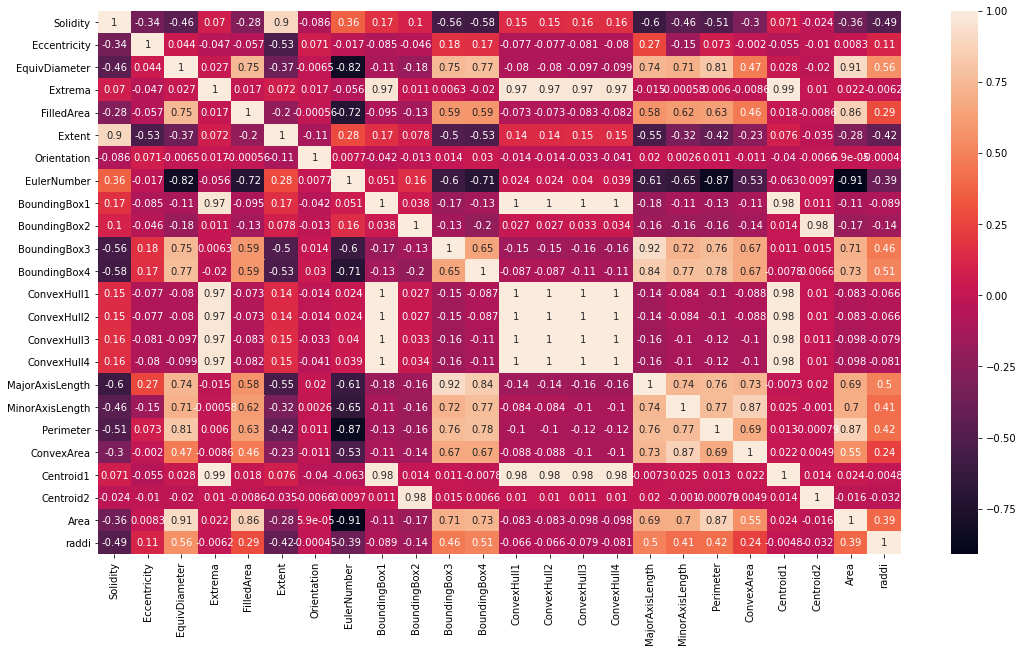

In [4]:
plt.subplots(figsize=(18,10))
sns.heatmap(df.corr(), annot=True)

In [5]:
#inspect class imbalance
class_balance = pd.DataFrame(df.microorganisms.value_counts())
class_balance['Occ'] = df.microorganisms.value_counts(normalize=True)
class_balance.columns = ['Count', 'Percentage']
class_balance

,Count,Percentage
Ulothrix,7420,0.243064
Volvox,4320,0.141514
Protozoa,3888,0.127363
Aspergillus sp,3888,0.127363
Yeast,3600,0.117928
Raizopus,2552,0.083598
Diatom,1818,0.059554
Pithophora,1350,0.044223
Penicillum,1080,0.035379
Spirogyra,611,0.020015


## Data Preparation
temp (preprocessing/cleaning)\[add md for each step\]

In [6]:

X = df.drop('microorganisms', axis=1)
y = df.microorganisms
X_train, X_test, y_train, y_test = train_test_split(X,y)

## Modeling
temp(either as steps or summary of types)\[need md desc for each\]

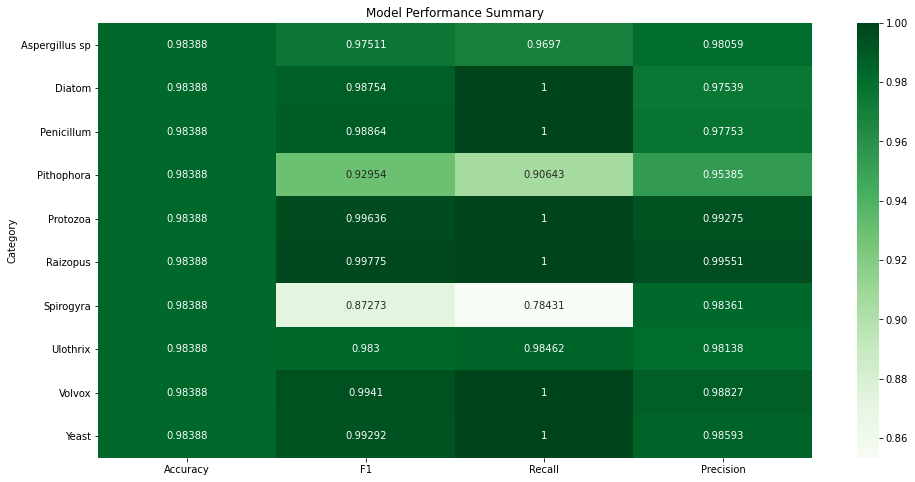

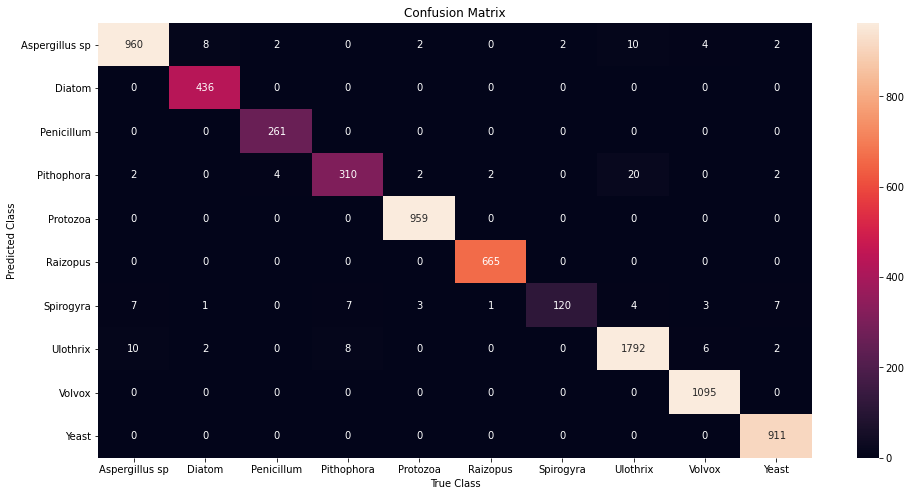

In [7]:
#baseline (compare smote/weights?)

def getConfusionMatrix(estimator, data, target, labels=None):
    preds = estimator.predict(data)
    matrix_raw = confusion_matrix(target, preds)
    dfMatrix = pd.DataFrame(matrix_raw, index=labels, columns=labels)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfMatrix, annot=True, robust=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class')
    return dfMatrix

def getScore(estimator, data, target, labels = None):
    preds = estimator.predict(data)
    results = {}
    results['Accuracy'] = accuracy_score(target, preds)
    results['F1'] = f1_score(target, preds, average=None)
    results['Recall'] = recall_score(target, preds, average=None)
    results['Precision'] = precision_score(target, preds, average=None)
    
    dfResults = pd.DataFrame(results, index=labels)
    #print(dfResults)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfResults, annot=True, robust=True, cmap='Greens', fmt='0.5g')
    plt.title('Model Performance Summary')
    plt.ylabel('Category')
    return dfResults


baseline = Pipeline([('scaler', StandardScaler()), 
                    ('clf', DecisionTreeClassifier())])

baseline.fit(X_train, y_train)

labels = y_test.value_counts().index
labels = labels.sort_values()

test_base = getScore(baseline, X_test, y_test, labels)
#print(test_base['F1'].mean())
conf_base = getConfusionMatrix(baseline, X_test, y_test, labels)

In [8]:
if exists('models/baseline_custom.pkl'):
    with open('models/baseline_custom.pkl', 'rb') as f:
        baseline_custom = joblib.load(f)
else:
    baseline_custome_pipe = Pipeline([('scaler', StandardScaler()), 
                        ('clf', DecisionTreeClassifier())])

    dt_param_grid = {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 2, 4, 6],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 3, 5]
    }



    baseline_custom = GridSearchCV(estimator=baseline_custome_pipe, 
                                   param_grid=dt_param_grid, 
                                   cv=3, 
                                   verbose=2, 
                                   scoring='f1_macro')

    baseline_custom.fit(X_train, y_train)
    
    with open('models/baseline_custom.pkl', 'wb') as f:
        joblib.dump(baseline_custom, f)
    
    
baseline_custom.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2}

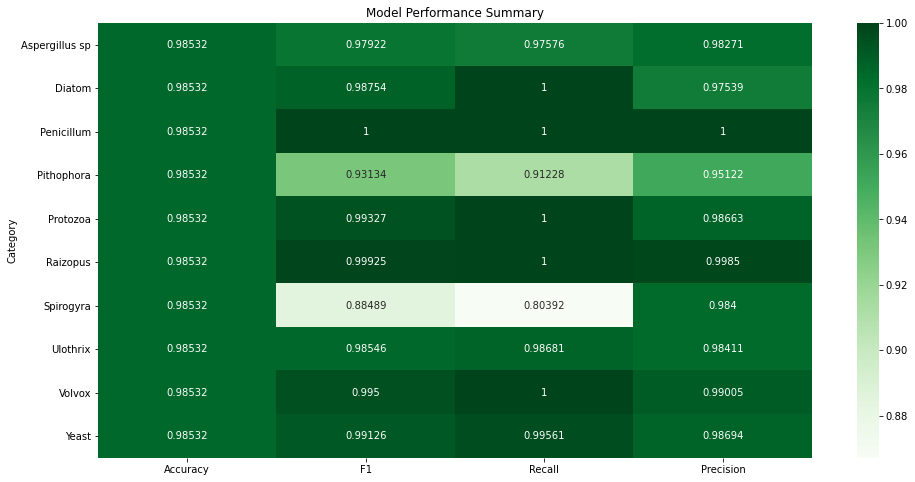

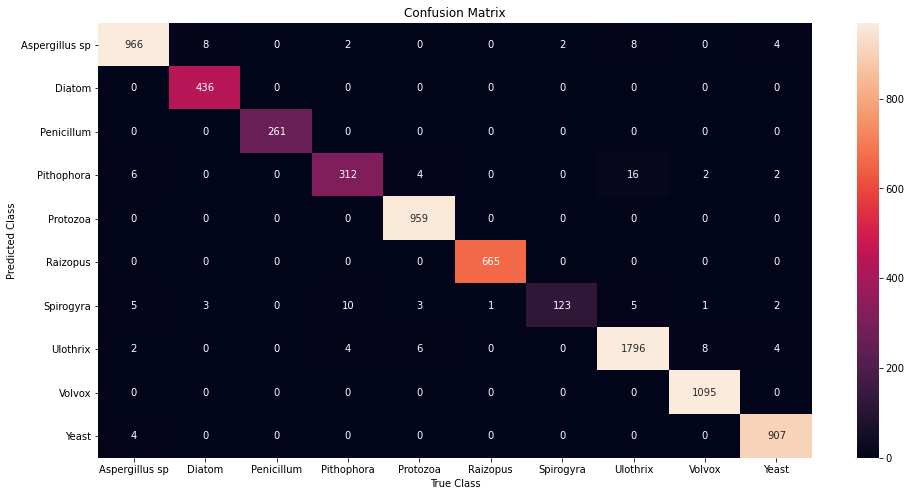

In [9]:
labels = y_test.value_counts().index
labels = labels.sort_values()

test_base_custom = getScore(baseline_custom, X_test, y_test, labels)
#print(test_base_custom['F1'].mean())
conf_base_custom = getConfusionMatrix(baseline_custom, X_test, y_test, labels)

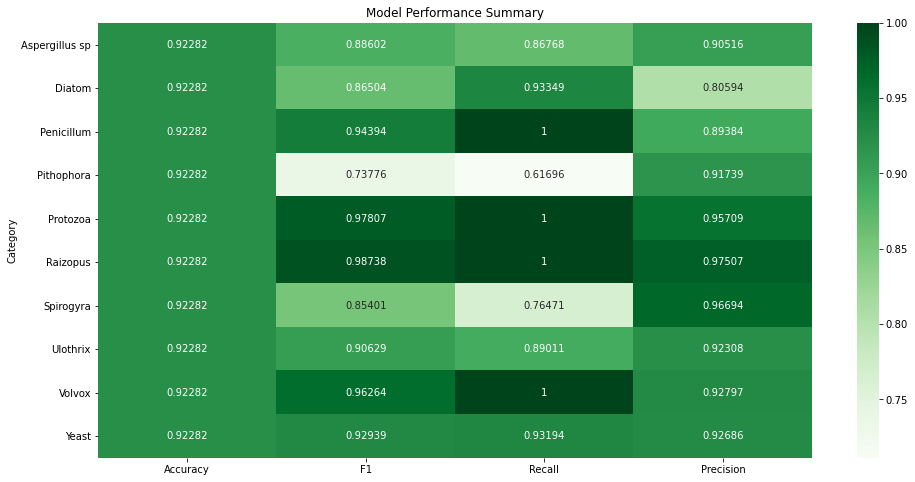

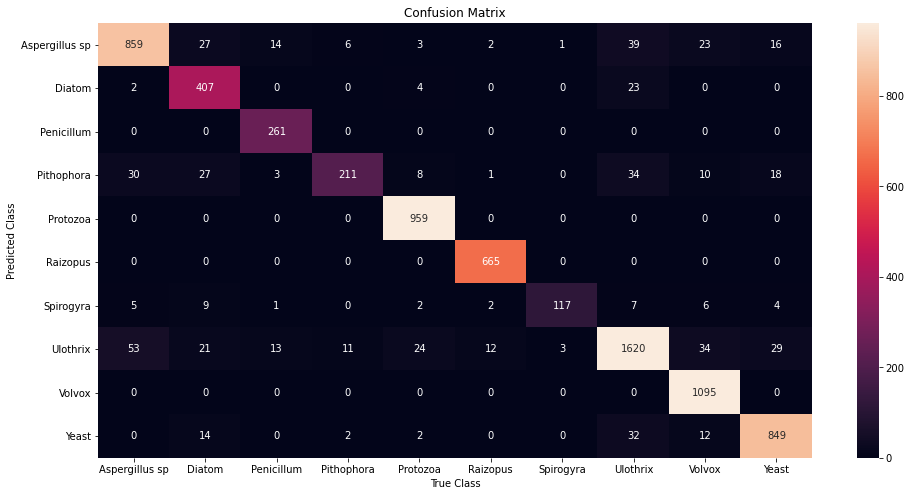

In [10]:
#knn base, knn tuned
knn_default = imbPipe([('scaler', StandardScaler()), 
                    ('knn', KNeighborsClassifier())])

knn_default.fit(X_train, y_train)

labels = y_test.value_counts().index
labels = labels.sort_values()

test_knn_default = getScore(knn_default, X_test, y_test, labels)
#print(test_knn_default['F1'].mean())
conf_knn_default = getConfusionMatrix(knn_default, X_test, y_test, labels)


In [11]:

if exists('models/knn_custom.pkl'):
    with open('models/knn_custom.pkl', 'rb') as f:
        knn_custom = joblib.load(f)
else:
    knn_custom_pipe = imbPipe([('scaler', StandardScaler()), 
                    ('smote', SMOTE()),
                    ('knn', KNeighborsClassifier(n_neighbors=1, p=1))])
    
    knn_param_grid = {
        'knn__weights': ['uniform', 'distance'],
        'knn__n_neighbors': [1, 5, 10, 15],
        'knn__p': [1, 2, 3],
        'knn__leaf_size': [15, 30, 45]
    }



    knn_custom = GridSearchCV(estimator=knn_custom_pipe, 
                                   param_grid=knn_param_grid, 
                                   cv=3, 
                                   verbose=2, 
                                   scoring='f1_macro')

    knn_custom.fit(X_train, y_train)
    
    with open('models/knn_custom.pkl', 'wb') as f:
        joblib.dump(knn_custom, f)
    
    
knn_custom.best_params_

{'knn__leaf_size': 45,
 'knn__n_neighbors': 1,
 'knn__p': 1,
 'knn__weights': 'uniform'}

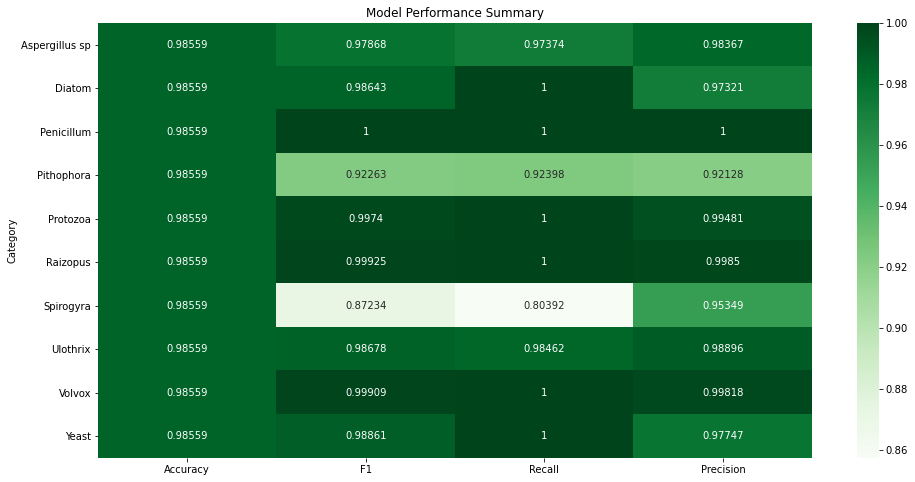

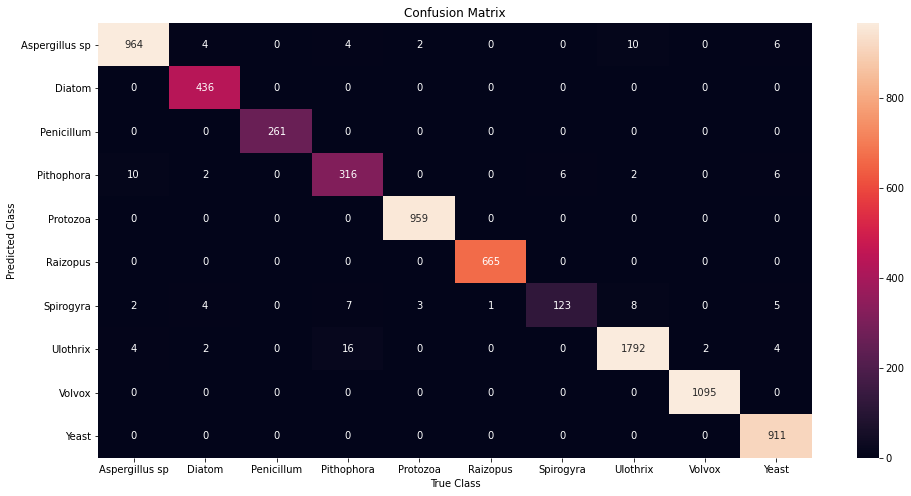

In [12]:
labels = y_test.value_counts().index
labels = labels.sort_values()

test_knn_custom = getScore(knn_custom, X_test, y_test, labels)
#print(test_knn_custom['F1'].mean())
conf_knn_custom = getConfusionMatrix(knn_custom, X_test, y_test, labels)

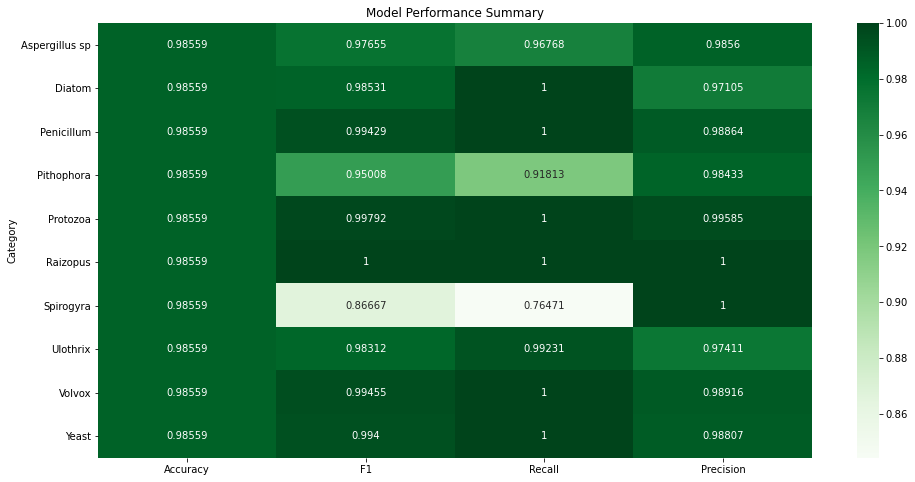

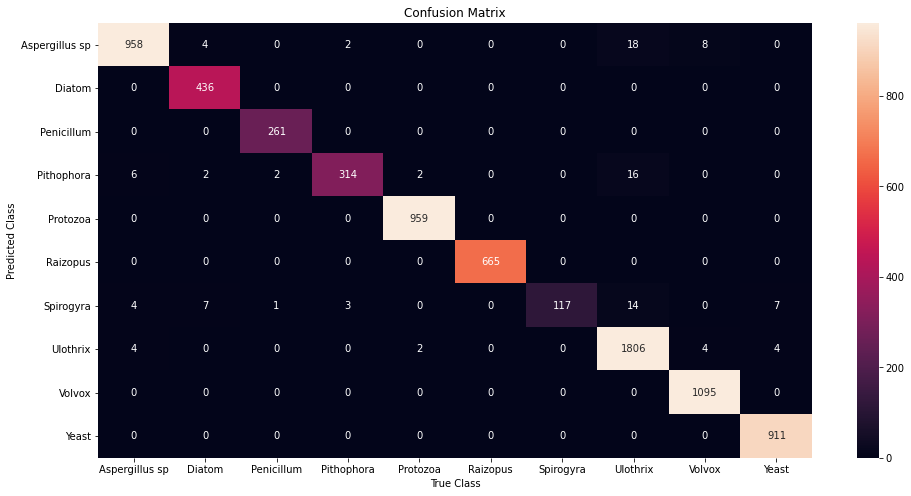

In [13]:

forest_default = imbPipe([('scaler', StandardScaler()), 
                    ('forest', RandomForestClassifier())])

forest_default.fit(X_train, y_train)

labels = y_test.value_counts().index
labels = labels.sort_values()

test_forest_default = getScore(forest_default, X_test, y_test, labels)
#print(test_forest_default['F1'].mean())
conf_forest_default = getConfusionMatrix(forest_default, X_test, y_test, labels)

In [14]:
#forest base, forest tuned


if exists('models/forest_custom.pkl'):
    with open('models/forest_custom.pkl', 'rb') as f:
        forest_custom = joblib.load(f)
else:
    forest_custom_pipe = imbPipe([('scaler', StandardScaler()), 
                    ('forest', RandomForestClassifier())])

    rf_param_grid = {
        'forest__n_estimators': [30, 50, 80],
        'forest__criterion': ['gini', 'entropy'],
        'forest__max_depth': [None, 2, 4, 6],
        'forest__min_samples_split': [2, 5, 10],
        'forest__min_samples_leaf': [1, 3, 5],
        'forest__class_weight': [None, 'balanced']
    }



    forest_custom = GridSearchCV(estimator=forest_custom_pipe, 
                                   param_grid=rf_param_grid, 
                                   cv=3, 
                                   verbose=2, 
                                   scoring='f1_macro')

    forest_custom.fit(X_train, y_train)
    
    with open('models/forest_custom.pkl', 'wb') as f:
        joblib.dump(forest_custom, f)
    
    
forest_custom.best_params_

{'forest__class_weight': None,
 'forest__criterion': 'gini',
 'forest__max_depth': None,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 2,
 'forest__n_estimators': 30}

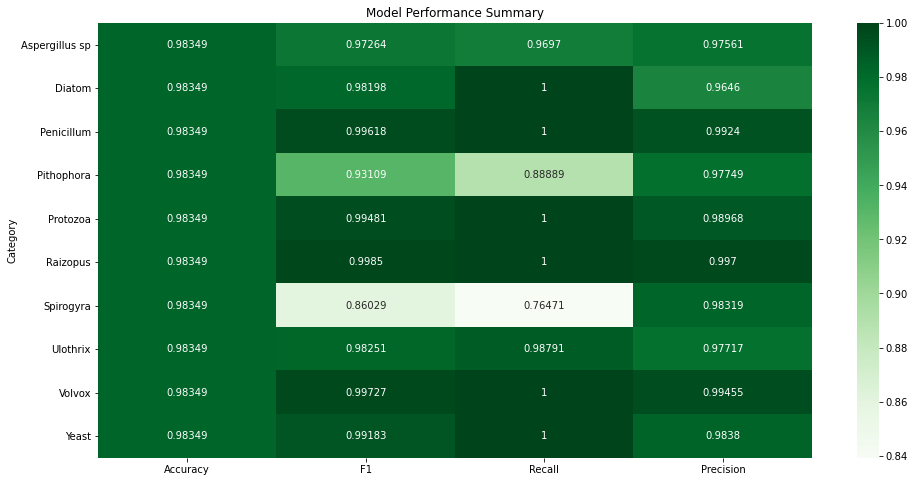

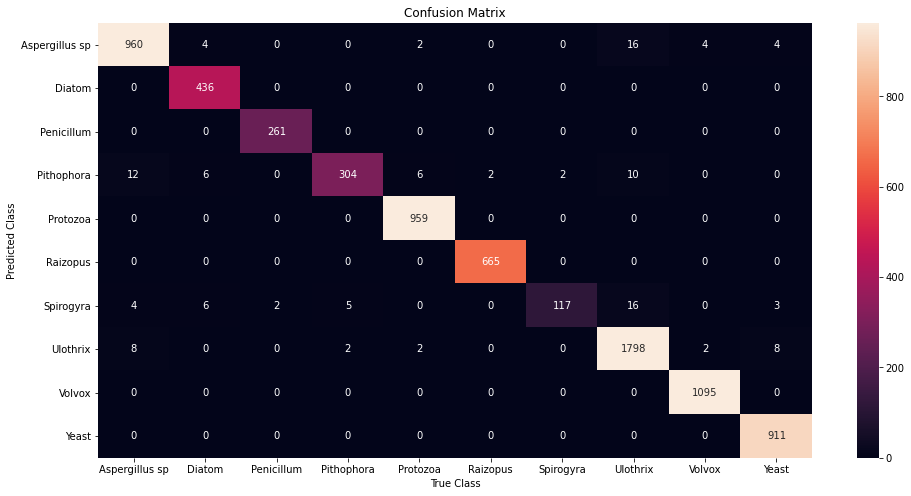

In [15]:
labels = y_test.value_counts().index
labels = labels.sort_values()

test_forest_custom = getScore(forest_custom, X_test, y_test, labels)
#print(test_forest_custom['F1'].mean())
conf_forest_custom = getConfusionMatrix(forest_custom, X_test, y_test, labels)

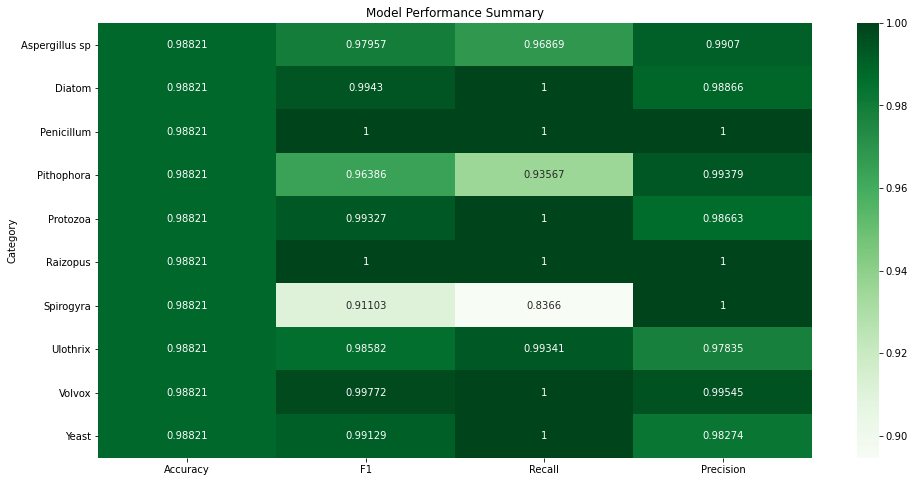

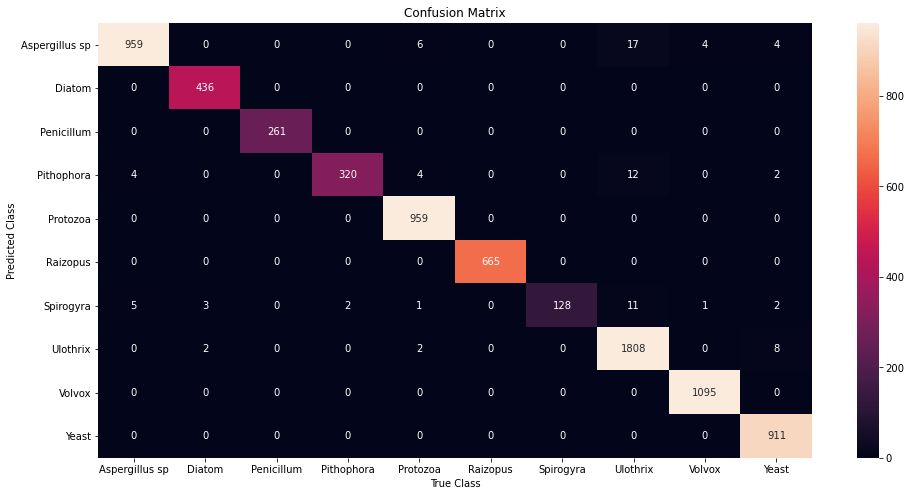

In [16]:

XGB_default = imbPipe([('scaler', StandardScaler()), 
                    ('XGB', XGBClassifier())])

XGB_default.fit(X_train, y_train)

labels = y_test.value_counts().index
labels = labels.sort_values()

test_XGB_default = getScore(XGB_default, X_test, y_test, labels)
#print(test_XGB_default['F1'].mean())
conf_XGB_default = getConfusionMatrix(XGB_default, X_test, y_test, labels)

In [17]:



#XGB_custom = XGBClassifier(learning_rate=0.3, 
#                        max_depth=None, 
#                        min_child_weight=1, 
#                        subsample=1, 
#                        grow_policy='depthwise')

#xgb_scaler = StandardScaler()
#X_train_scaled = xgb_scaler.fit_transform(X_train)
#X_test_scaled = xgb_scaler.transform(X_test)
                       
#XGB_custom.fit(X_train_scaled, y_train, sample_weight=samp_weights)



if exists('models/XGB_custom.pkl'):
    with open('models/XGB_custom.pkl', 'rb') as f:
        XGB_custom = joblib.load(f)
else:
    XGB_custom_pipe = imbPipe([('scaler', StandardScaler()), 
                    ('XGB', XGBClassifier())])

    XG_param_grid = {
        'XGB__learning_rate': [0.2, 0.3, 0.4],
        'XGB__max_depth': [None, 5, 10],
        'XGB__min_child_weight': [1, 3, 5],
        'XGB__subsample': [0.7, 0.8, 1],
        'XGB__grow_policy': ['depthwise', 'lossguide']
    }
    
    samp_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train)



    XGB_custom = GridSearchCV(estimator=XGB_custom_pipe, 
                                   param_grid=XG_param_grid, 
                                   cv=3, 
                                   verbose=2, 
                                   scoring='f1_macro')

    XGB_custom.fit(X_train, y_train, XGB__sample_weight=samp_weights)
    
    with open('models/XGB_custom.pkl', 'wb') as f:
        joblib.dump(forest_custom, f)
    
    
XGB_custom.best_params_







Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7, total=   9.6s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7, total=  10.0s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7, total=  10.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=   9.3s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=   9.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=None, X

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   6.8s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   6.8s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   7.6s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   8.0s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsa

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  11.6s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  11.6s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  12.1s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  10.1s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=3, XGB__subsample=1, total=   7.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   8.5s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   8.4s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   8.5s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=None, XGB

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=0.8, total=   7.4s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   6.1s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   6.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   6.1s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsam

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.7, total=   9.6s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=  10.5s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=  11.1s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=  10.5s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=None, X

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   7.8s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   8.0s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   8.9s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   9.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=3, XGB__s

[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  11.3s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  12.7s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  10.4s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  10.2s
[CV] XGB__grow_policy=depthwise, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=3, 

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   9.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   9.7s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   9.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8, total=   9.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=None, X

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   7.0s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   7.1s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   7.0s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7, total=  13.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.2, XGB__max_depth=10, XGB__min_child_weight=1, XGB__su

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=   9.6s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=   9.6s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=0.8, total=   9.6s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__min_child_weight=1, XGB__subsample=1, total=   8.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=None, XGB__

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=1, XGB__subsample=1, total=   7.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   8.8s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   8.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XGB__subsample=0.7, total=   8.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=5, XGB__min_child_weight=3, XG

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=0.8, total=  12.6s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  11.7s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  11.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=3, XGB__subsample=1, total=  11.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.3, XGB__max_depth=10, XGB__min_child_weight=5, XGB_

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   9.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.7, total=   9.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8, total=   9.4s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, XGB__min_child_weight=5, XGB__subsample=0.8, total=   9.5s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=None, X

[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   7.1s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=5, XGB__min_child_weight=5, XGB__subsample=1, total=   6.9s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7, total=  11.6s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7 
[CV]  XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=1, XGB__subsample=0.7, total=  12.1s
[CV] XGB__grow_policy=lossguide, XGB__learning_rate=0.4, XGB__max_depth=10, XGB__min_child_weight=1, X

[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed: 77.5min finished


{'XGB__grow_policy': 'depthwise',
 'XGB__learning_rate': 0.4,
 'XGB__max_depth': 10,
 'XGB__min_child_weight': 5,
 'XGB__subsample': 1}

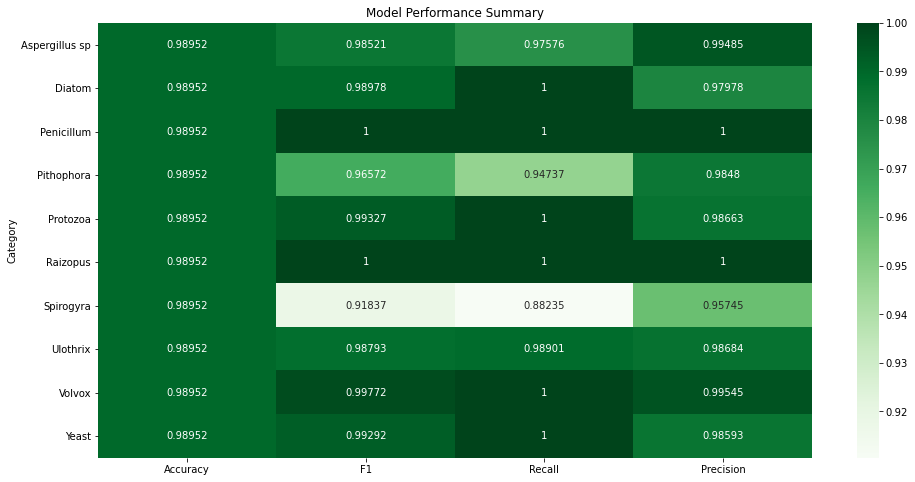

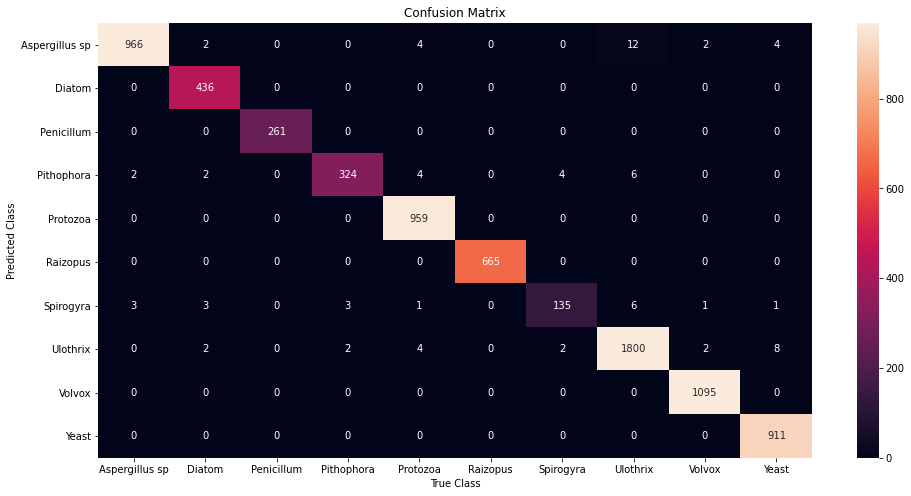

In [19]:

labels = y_test.value_counts().index
labels = labels.sort_values()

test_XGB_custom = getScore(XGB_custom, X_test, y_test, labels)
#print(test_XGB_custom['F1'].mean())
conf_XGB_custom = getConfusionMatrix(XGB_custom, X_test, y_test, labels)

## Findings

temp

### Predictive Ability
The final model posesses an accuracy of 98.9%, making it well suited to predicting the 10 categories in this data set. 

For the categories `Volvox`, `Yeast`, `Raizopus`, `Protozoa`, `Penicillium`, and `Diatom`, the model correctly identified all instances of these categories.

Other categories that had less prevalence in the dataset, such as `Spirogyra` and `Pithophora`, are not predicted as accurately.

Despite this, the overall performance of the model is very good, with a average F1 score of 0.9847

The graph below shows the average F1 score of the final model as compared to the other, earlier models.

Text(0.5, 0, 'Average F1 Score')

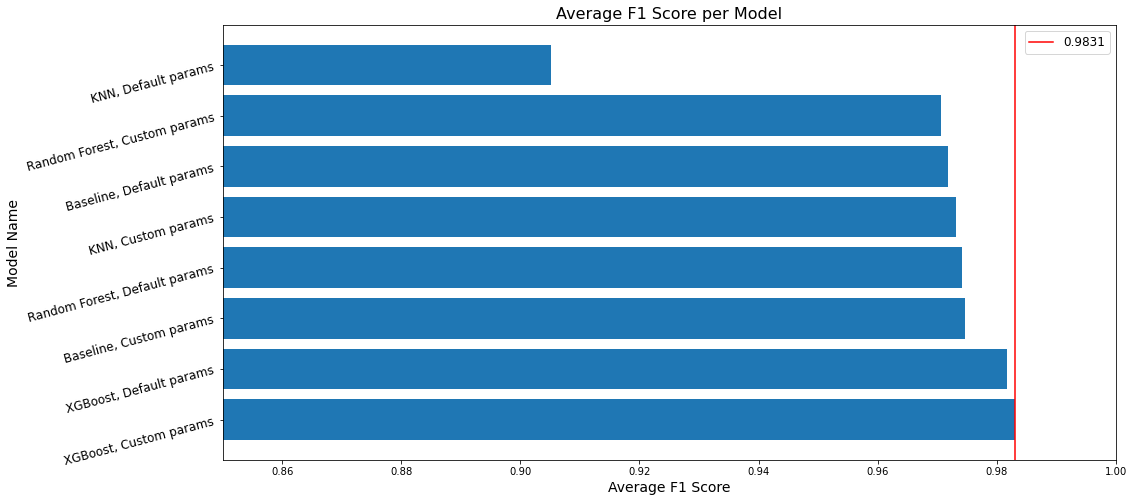

In [20]:
scores = {
    'Baseline, Default params' : test_base,
    'Baseline, Custom params' : test_base_custom,
    'Random Forest, Default params' : test_forest_default,
    'Random Forest, Custom params' : test_forest_custom,
    'KNN, Default params' : test_knn_default,
    'KNN, Custom params': test_knn_custom,
    'XGBoost, Default params' : test_XGB_default,
    'XGBoost, Custom params' : test_XGB_custom
}

dfFind1 = pd.DataFrame([(x['F1'].mean() for x in scores.values())], columns=scores.keys())
dfFind1 = dfFind1.T
dfFind1.columns = ['Average F1 Score']
dfFind1.sort_values(by='Average F1 Score', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(16,8))
ax.barh((range(len(scores))), dfFind1['Average F1 Score'], align='center')
       
plt.yticks(np.arange(len(scores)), dfFind1.index)
plt.yticks(rotation=15, fontsize=12)
plt.xlim(0.85, 1.0)

plt.axvline(scores['XGBoost, Custom params']['F1'].mean(), 
            color='r', 
            label=round(scores['XGBoost, Custom params']['F1'].mean(),4))
plt.legend(fontsize=12)
plt.title('Average F1 Score per Model', fontsize=16)
plt.ylabel('Model Name', fontsize=14)
plt.xlabel('Average F1 Score', fontsize=14)

### Feature Importance

The final model prioritized the feature `ConvexArea` highest, followed by `raddi` and `Perimeter`.

This is distinct from the earlier Random Forest models, which focuesd more on `raddi`, while `ConvexArea` was only the fourth most important feature. The graph below visualizes this.


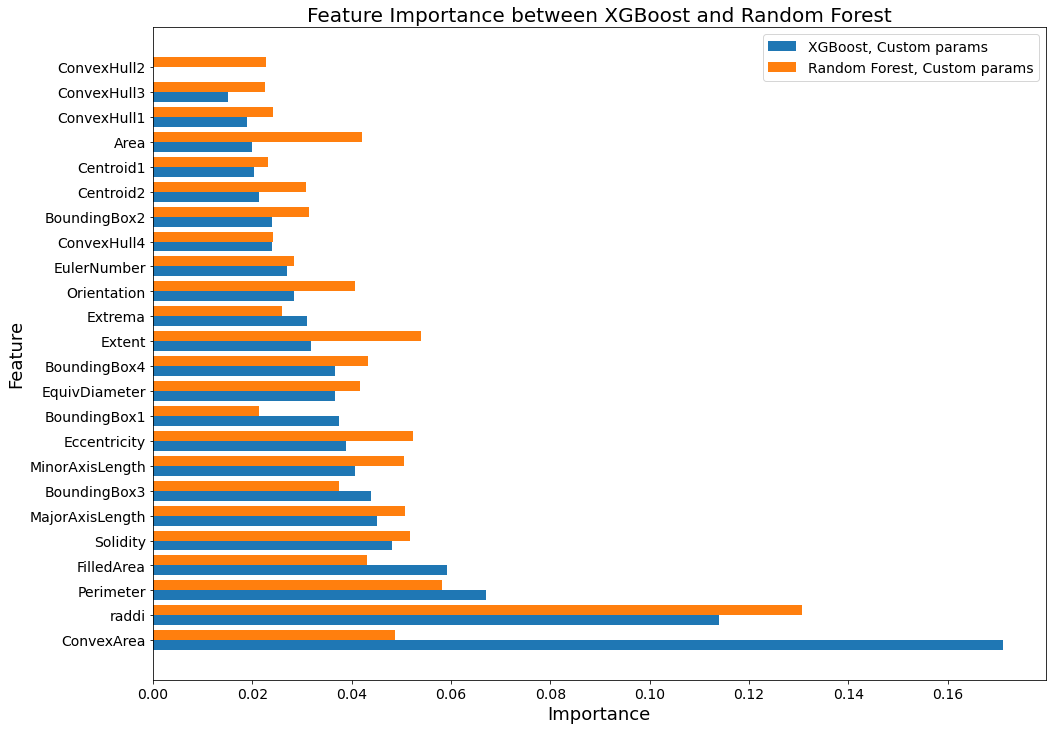

In [22]:
def compare_feature_importances(model1, model2, model_labels):
    n_features = X_train.shape[1]
    plt.figure(figsize=(16,12))
    
    dfImport = pd.DataFrame([model1.feature_importances_], columns=X_train.columns.values)
    dfImport = dfImport.T
    dfImport.columns = [(model_labels[0].split(',')[0] + ' Importance')]
    dfImport[model_labels[1].split(',')[0] + ' Importance'] = model2.feature_importances_
    
    dfImport.sort_values(by=(model_labels[0].split(',')[0] + ' Importance'), ascending=False, inplace=True)
    
    plt.barh(np.arange(n_features) - 0.2, 
             dfImport[model_labels[0].split(',')[0] + ' Importance'], 
             0.4, 
             align='center', 
             label=model_labels[0])
    
    plt.barh(np.arange(n_features) + 0.2, 
             dfImport[model_labels[1].split(',')[0] + ' Importance'], 
             0.4, 
             align='center', 
             label=model_labels[1])
    
    plt.yticks(np.arange(n_features), dfImport.index) 
    plt.xlabel('Importance', fontsize=18)
    plt.ylabel('Feature', fontsize=18)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title(f'''Feature Importance between {model_labels[0].split(',')[0]} and {model_labels[1].split(',')[0]}''', 
              fontsize=20)
    
model_names = ['XGBoost, Custom params', 'Random Forest, Custom params']
compare_feature_importances(XGB_custom.best_estimator_.named_steps['XGB'], 
#                            forest_custom.named_steps[list(forest_custom.named_steps.keys())[-1]], 
                            forest_custom.best_estimator_.named_steps['forest'],
                            model_names)

## Recommendations
temp


### Deploy Model for Use

The final model's predictive ability is sufficient for applications requiring rapid identification of microorganisms between the model's 10 categories. An example of this would be determining antibiotic resistance for patients in septic shock as a result of a bacterial infection.


If the model is either available locally or hosted as a webapp, a technician would be able to recieve results immediately after the extracted image data is sent.

An important caveat is that the model is less effective at predicting Spirogyra compared to other genera. The graph below visualizes this difference. It is important to keep this limitation in mind, as other methods of identification may be preferable in situations where detecting microorganisms of the Spirogyra genus is critical.

Text(0.5, 0, 'Percentage of Incorrect Predictions')

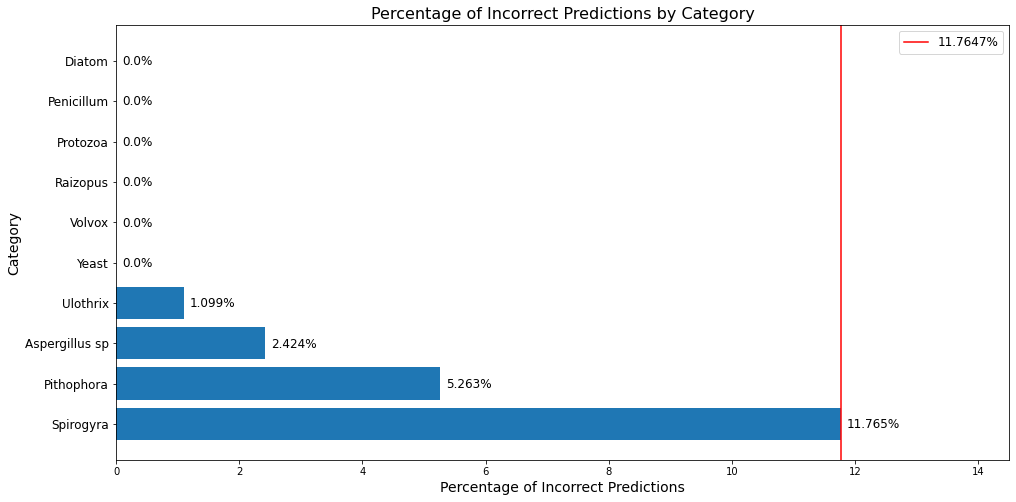

In [23]:
fig, ax = plt.subplots(figsize=(16,8))

dfRec1 = (1 - test_XGB_custom['Recall']) * 100
dfRec1.sort_values(ascending=False, inplace=True)


bars = plt.barh((range(len(dfRec1))), dfRec1)
for i, v in enumerate(dfRec1):
    plt.text(v + 0.1, i - 0.1, str(round(v,3)) + '%', fontsize=12)
plt.yticks(np.arange(len(dfRec1)), dfRec1.index)
plt.yticks(rotation=0, fontsize=12)
plt.xlim(0, 14.5)

plt.axvline(dfRec1.max(), 
            color='r', 
            label=str(round(dfRec1.max(),4)) + '%')


plt.legend(fontsize=12, loc='upper right')
plt.title('Percentage of Incorrect Predictions by Category', fontsize=16)
plt.ylabel('Category', fontsize=14)
plt.xlabel('Percentage of Incorrect Predictions', fontsize=14)

### Collect Additional Spirogyra Data

With more data, it may be possible to improve the effectiveness of this model further.
As the graphs below show, the troubled category `Spirogyra` is also the category with the least data samples. Therefore, collecting more `Spirogyra` data should improve the model's ability to detect microorganisms of this genus.


Text(0.5, 1.0, 'Category F1 Scores (Final Model)')

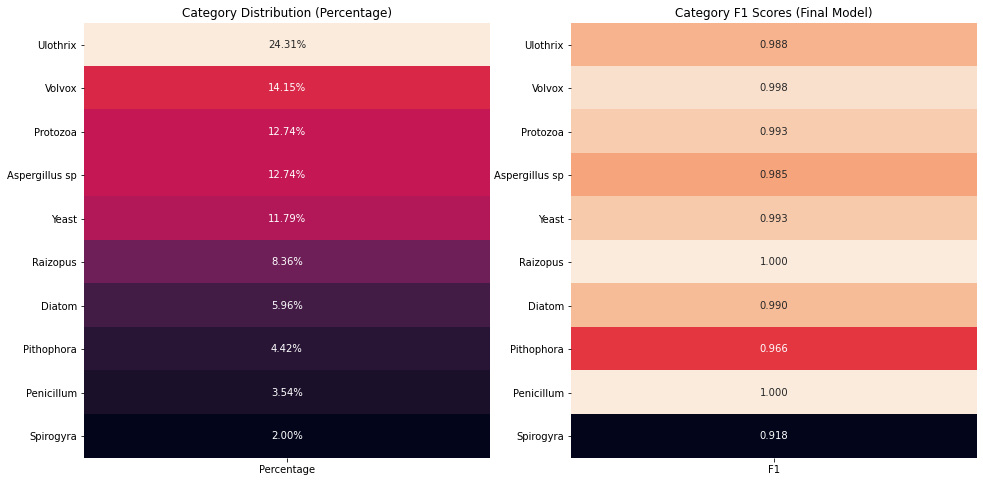

In [24]:
dfRec2 = class_balance[['Percentage']]
dfRec2['F1 Score'] = test_XGB_custom['F1']
dfRec2
fig, ax = plt.subplots(figsize=(16,8), ncols=2)

sns.heatmap(class_balance[['Percentage']], 
            annot=True, 
            fmt = '.2%', 
            ax=ax[0], 
            cbar=False)
ax[0].set_title('Category Distribution (Percentage)')

sns.heatmap(test_XGB_custom[['F1']].reindex(class_balance[['Percentage']].index), 
            annot=True, 
            fmt = '.3f', 
            ax=ax[1], 
            cbar=False)
ax[1].set_title('Category F1 Scores (Final Model)')

### Increase Accuracy of Key Features

Certain features of the data are more helpful in determining the type of microorganism than others. The two features that are most significant to the final model are `ConvexArea` and `raddi`.

In the current dataset, `ConvexArea` is recorded to three decimal places of accuracy while `raddi` is recorded to only two.
If these features are recorded to a greater degree of detail, the model's predictive ability may be improved.


Text(0.5, 1.0, 'Final Model Feature Importance')

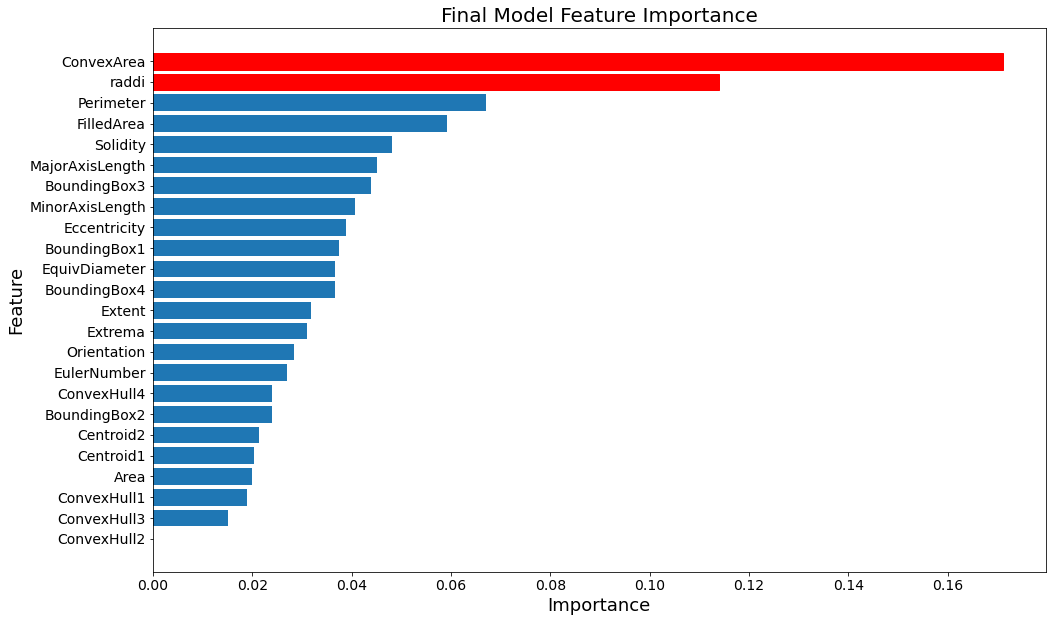

In [26]:
dfRec1 = pd.DataFrame([XGB_custom.best_estimator_.named_steps['XGB'].feature_importances_], columns=X_train.columns.values)
dfRec1 = dfRec1.T
dfRec1.columns = ['Importance']
dfRec1.sort_values(by='Importance', ascending=True, inplace=True)
n_features = X_train.shape[1]

plt.figure(figsize=(16,10))

barList = plt.barh(np.arange(n_features), dfRec1['Importance'], align='center', label='temp')
barList[-1].set_color('r')
barList[-2].set_color('r')

plt.yticks(np.arange(n_features), dfRec1.index) 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.title('Final Model Feature Importance', fontsize=20)

### Next steps
temp